In [39]:
def in_jupyter():
    try:
        from IPython import get_ipython
        shell = get_ipython().__class__.__name__
        print(f"Running in shell: {shell}")
        return shell == "ZMQInteractiveShell"
    except Exception:
        return False

if in_jupyter():
    from IPython import get_ipython
    ip = get_ipython()
    ip.run_line_magic("load_ext", "autoreload")
    ip.run_line_magic("autoreload", "3")


import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")


Running in shell: ZMQInteractiveShell
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# LOAD BASE DATASET

from cwc.src.data import Dataset


dataset = Dataset()
dataset.load_from_mat("cwc/data/D1.mat")

print("Loaded Dataset:")
print("\tData shape:", dataset.data.shape)
print("\tIndices shape:", dataset.indices.shape)
print("\tClasses shape:", dataset.classes.shape)
print("\tUnique classes:", np.unique(dataset.classes))
print("\tClass instances:", np.bincount(dataset.classes))
print("\tMin distance between spikes:", np.min(np.diff(np.sort(dataset.indices))))

# SPLIT DATASET INTO TRAINING AND TEST SETS

train_data = dataset
test_data = train_data.split_into_test(test_ratio=0.2)

# print basic info about the training and test sets
print("\nTraining Set:")
print("\tData shape:", train_data.data.shape)
print("\tIndices shape:", train_data.indices.shape)
print("\tClasses shape:", train_data.classes.shape)
print("\tClass instances:", np.bincount(train_data.classes))
print("\nTest Set:")
print("\tData shape:", test_data.data.shape)
print("\tIndices shape:", test_data.indices.shape)
print("\tClasses shape:", test_data.classes.shape)
print("\tClass instances:", np.bincount(test_data.classes))


Loaded Dataset:
	Data shape: (1440000,)
	Indices shape: (2176,)
	Classes shape: (2176,)
	Unique classes: [1 2 3 4 5]
	Class instances: [  0 458 441 406 444 427]
	Min distance between spikes: 1

Training Set:
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]

Test Set:
	Data shape: (288000,)
	Indices shape: (413,)
	Classes shape: (413,)
	Class instances: [  0 104  74  83  73  79]


Running in shell: ZMQInteractiveShell


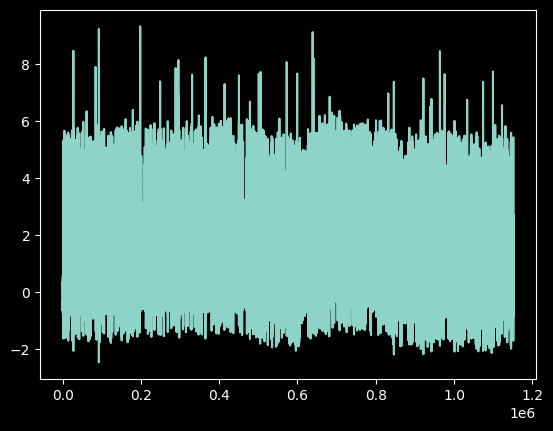

Running in shell: ZMQInteractiveShell


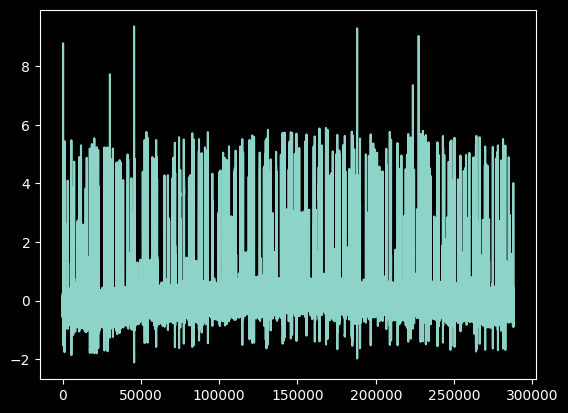

In [41]:

if in_jupyter():
    plt.plot(train_data.data)
    plt.show()

if in_jupyter():
    plt.plot(test_data.data)
    plt.show()

Running in shell: ZMQInteractiveShell


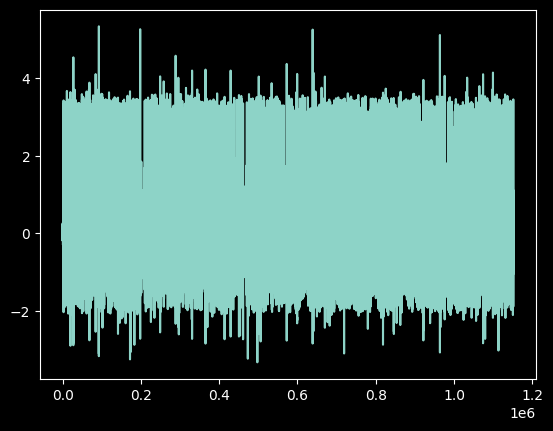

Running in shell: ZMQInteractiveShell


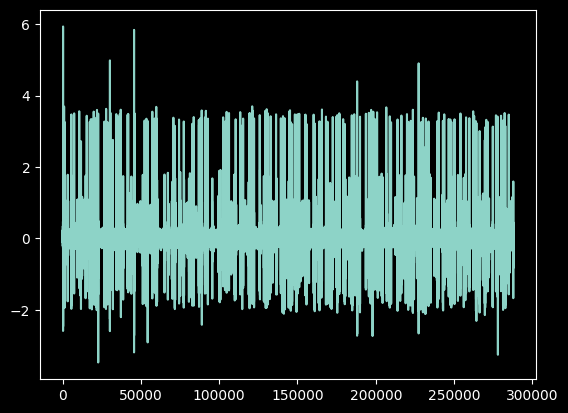

In [42]:
from cwc.src.signal import BandpassFilter
import matplotlib.pyplot as plt

train_filter = BandpassFilter(train_data)
train_filter.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)

test_filter = BandpassFilter(test_data)
test_filter.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)

if in_jupyter():
    plt.plot(train_filter.filtered_data)
    plt.show()

if in_jupyter():
    plt.plot(test_filter.filtered_data)
    plt.show()


Running in shell: ZMQInteractiveShell


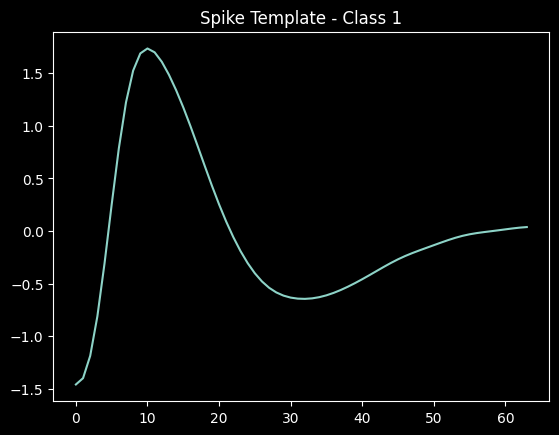

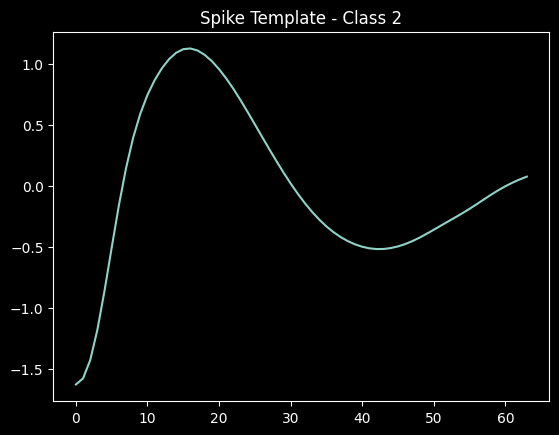

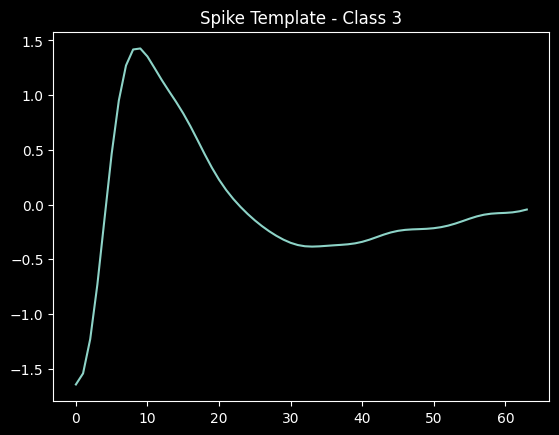

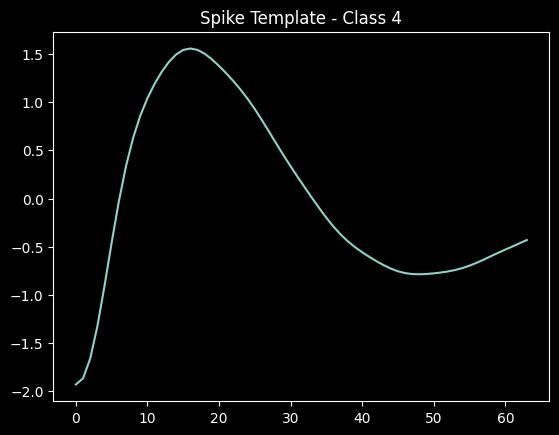

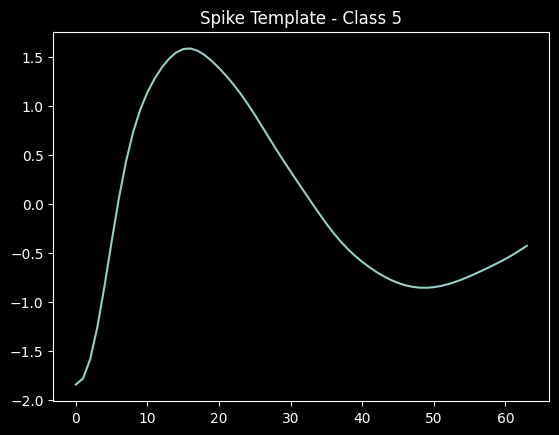

In [52]:
## NEW APPROACH - TEMPLATING

from cwc.src.signal import Templator

templator = Templator(train_filter) 
templator.create_templates(window_size=64, initial_offset=20, target_offset=0)

if in_jupyter():
    i = 1
    for template in templator.templates:
        plt.plot(template)
        plt.title("Spike Template - Class " + str(i))
        i += 1
        plt.show()


Training Set Spike Detection:
	Correct Detections: 1682 out of  1763
	False Positives: 93
	False Negatives: 81
	Incorrect Detections: 174
	Accuracy: 90.62%
Running in shell: ZMQInteractiveShell


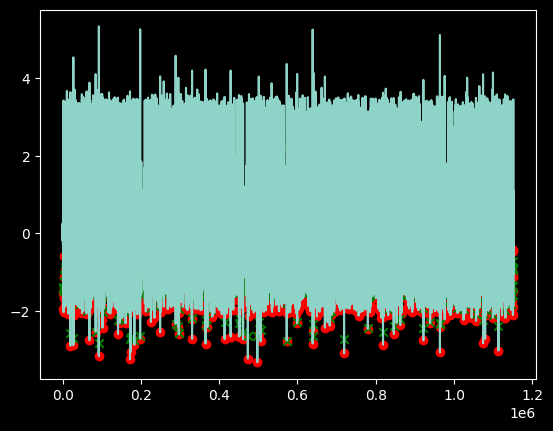

In [55]:
# TEST PURE MAD SPIKE DETECTION

from cwc.src.signal import SpikeDetector

mad_gain = 3.3
min_distance = 60

train_spikes = SpikeDetector(train_filter)
train_mad = train_spikes.calculate_mad()
train_spikes.detect_spikes(mad=train_mad, mad_gain=mad_gain, distance=min_distance)

test_spikes = SpikeDetector(test_filter)
test_mad = test_spikes.calculate_mad()
test_spikes.detect_spikes(mad=test_mad, mad_gain=mad_gain, distance=min_distance)

## evaluate spike detection performance on training set
correct_detections = 0
false_positives = 0
false_negatives = 0

for detected_spike in train_spikes.detected_spikes:
    if any(np.abs(train_spikes.indices - detected_spike) <= min_distance):
        correct_detections += 1
    else:
        false_positives += 1

incorrect_detections = false_positives + (len(train_spikes.indices) - correct_detections)

print("Training Set Spike Detection:")
print("\tCorrect Detections:", correct_detections, "out of ", len(train_spikes.indices))
print("\tFalse Positives:", false_positives)
print("\tFalse Negatives:", len(train_spikes.indices) - correct_detections)
print("\tIncorrect Detections:", incorrect_detections)
print("\tAccuracy: {:.2f}%".format(100 * correct_detections / (correct_detections + incorrect_detections)))


# plot detected spikes on training data, alonside the true spike indices

if in_jupyter():
    plt.plot(train_filter.filtered_data)
    plt.scatter(train_spikes.detected_spikes, train_filter.filtered_data[train_spikes.detected_spikes], color='red')
    plt.scatter(train_spikes.indices, train_filter.filtered_data[train_spikes.indices], color='green', marker='x')
    plt.show()


Training Set Spike Detection:
	Correct Detections: 2564 out of  1763
	False Positives: 607
	False Negatives: -801
	Incorrect Detections: -194
	Accuracy: 108.19%
Running in shell: ZMQInteractiveShell


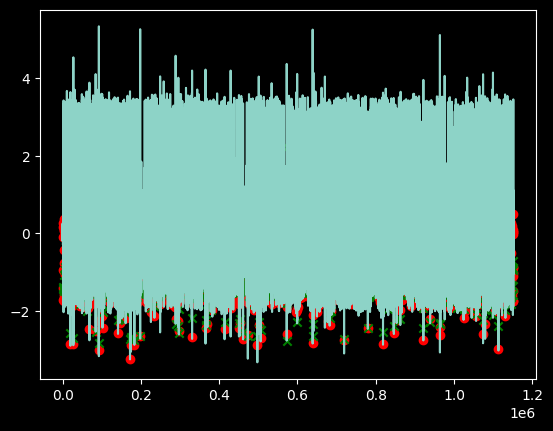

In [56]:
# NOW, TEST NON-OVERLAPPING TEMPLATE MATCHING 

templator.detect_with_templates(
    correlation_threshold=0.60,
    min_distance=25)

## evaluate spike detection performance on training set
correct_detections = 0
false_positives = 0
false_negatives = 0

for detected_spike in templator.indices:
    if any(np.abs(train_spikes.indices - detected_spike) <= min_distance):
        correct_detections += 1
    else:
        false_positives += 1

incorrect_detections = false_positives + (len(train_spikes.indices) - correct_detections)

print("Training Set Spike Detection:")
print("\tCorrect Detections:", correct_detections, "out of ", len(train_spikes.indices))
print("\tFalse Positives:", false_positives)
print("\tFalse Negatives:", len(train_spikes.indices) - correct_detections)
print("\tIncorrect Detections:", incorrect_detections)
print("\tAccuracy: {:.2f}%".format(100 * correct_detections / (correct_detections + incorrect_detections)))


# plot detected spikes on training data, alonside the true spike indices

if in_jupyter():
    plt.plot(train_filter.filtered_data)
    plt.scatter(templator.indices, train_filter.filtered_data[templator.indices], color='red')
    plt.scatter(train_spikes.indices, train_filter.filtered_data[train_spikes.indices], color='green', marker='x')
    plt.show()
